<a href="https://colab.research.google.com/github/wittyicon29/Tweet-Emotion-recognition-RNN/blob/main/Tweet_Emotion_Recognition_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 33.7 MB/s 
     |████████████████████████████████| 212 kB 39.3 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


Dataset

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets =[x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

Tokenizer - Converting Wordical labels to numerical

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

Padding and Truncating

(array([  8.,  45., 310., 488., 539., 625., 626., 629., 613., 636., 654.,
        655., 608., 622., 609., 603., 559., 535., 530., 510., 452., 430.,
        382., 385., 330., 327., 336., 317., 238., 208., 200., 200., 167.,
        157., 141., 144., 120., 117., 117.,  88.,  96.,  72.,  66.,  66.,
         65.,  52.,  37.,  43.,  30.,  32.,  31.,  26.,  30.,  20.,  23.,
         14.,   9.,  10.,   4.,   4.,   4.,   1.,   4.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.]),
 <a list of 64 Patch objects>)

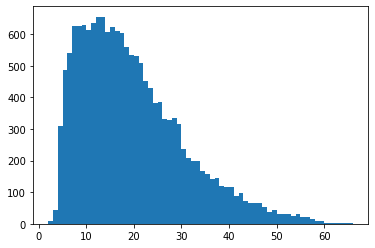

In [ ]:
lengths = [len(t.split(' '))for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded =pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Preparing the Labels

In [ ]:
classes = set(labels)
print(classes)

{'love', 'anger', 'fear', 'surprise', 'sadness', 'joy'}


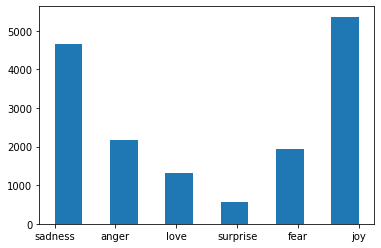

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{'love': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'sadness': 4, 'joy': 5}

In [ ]:
index_to_class

{0: 'love', 1: 'anger', 2: 'fear', 3: 'surprise', 4: 'sadness', 5: 'joy'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels  = names_to_ids(labels)
print(train_labels[0])

4


Creating the Model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


Training

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [ ]:
h = model.fit(
    padded_train_seq, 
    train_labels, 
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 16s 15ms/step - loss: 1.4062 - accuracy: 0.3876 - val_loss: 1.1413 - val_accuracy: 0.4820
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.7260 - accuracy: 0.7058 - val_loss: 0.6474 - val_accuracy: 0.7815
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3904 - accuracy: 0.8612 - val_loss: 0.4338 - val_accuracy: 0.8600
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2218 - accuracy: 0.9308 - val_loss: 0.4025 - val_accuracy: 0.8770
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1549 - accuracy: 0.9539 - val_loss: 0.3890 - val_accuracy: 0.8830
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1186 - accuracy: 0.9644 - val_loss: 0.3667 - val_accuracy: 0.8845
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0939 - accuracy: 0.9716 - val_loss: 0.3658 - val_accuracy: 0.890

Evaluation

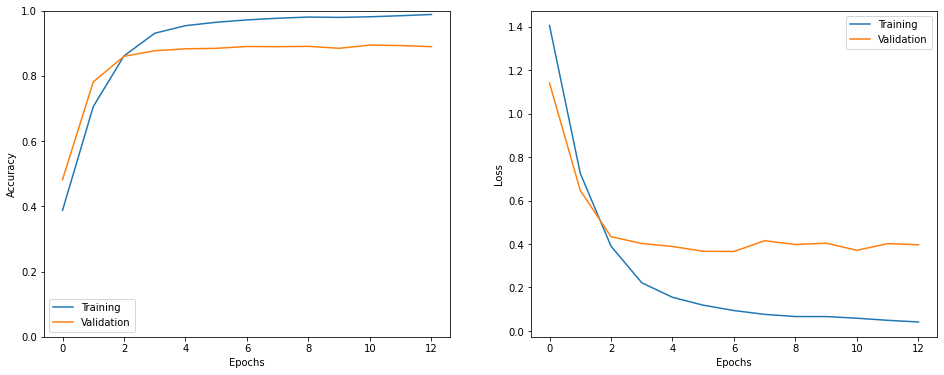

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_labels)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 1.7276 - accuracy: 0.4025


In [ ]:
import numpy as np

In [ ]:
i = np.random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: im amazed how many men say they feel unloved if the house is messy and they have to fix their own dinner
Emotion: sadness
Predicted Emotion: sadness
